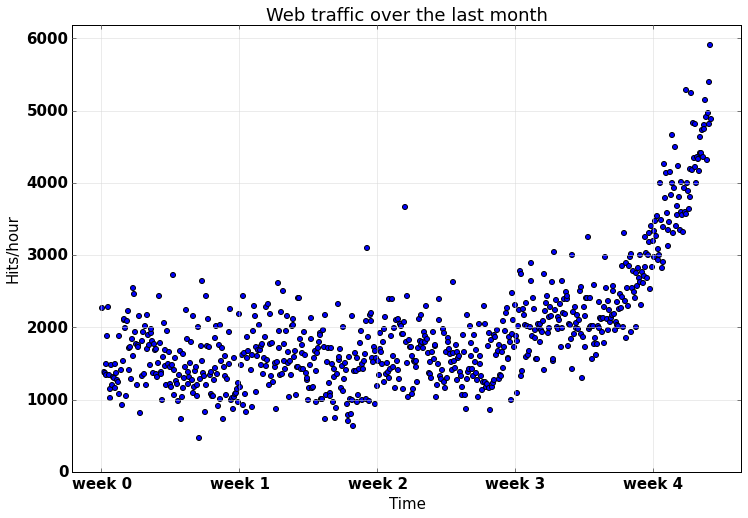

In [35]:
#Importing libraries. The same will be used throughout the article.
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import random
import matplotlib.pyplot as plt


%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

#----------------------------------------------------------------
data_dir = os.path.join(
    os.path.dirname(os.path.realpath("__file__")), "..", "data")
data = sp.genfromtxt(os.path.join(data_dir, "web_traffic.tsv"), delimiter="\t")

#Define input array with angles from 60deg to 300deg converted to radians
# x = np.array([i*np.pi/180 for i in range(60,300,4)])
# np.random.seed(10)  #Setting seed for reproducability
# y = np.sin(x) + np.random.normal(0,0.15,len(x))
x = data[:, 0]
y = data[:, 1]
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

def plot_models(x, y, models, fname, mx=None, ymax=None, xmin=None):
    plt.clf()
    plt.scatter(x, y, s=25)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.85')
    plt.savefig(fname)
    
# first look at the data
plot_models(x, y, None, os.path.join("..", "traffic_raw_data_regression.png"))

In [28]:
print data_dir

/Users/Ahmed/Documents/DataMining_Stuff/Machine-Learning/Tutorials/packt-tutorials/1400OS_Code/regression/code/../data


In [36]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print data.head()

   x     y  x_2  x_3   x_4   x_5    x_6     x_7      x_8       x_9      x_10  \
0  1  2272    1    1     1     1      1       1        1         1         1   
1  3  1386    9   27    81   243    729    2187     6561     19683     59049   
2  4  1365   16   64   256  1024   4096   16384    65536    262144   1048576   
3  5  1488   25  125   625  3125  15625   78125   390625   1953125   9765625   
4  6  1337   36  216  1296  7776  46656  279936  1679616  10077696  60466176   

        x_11        x_12         x_13         x_14          x_15  
0          1           1            1            1  1.000000e+00  
1     177147      531441      1594323      4782969  1.434891e+07  
2    4194304    16777216     67108864    268435456  1.073742e+09  
3   48828125   244140625   1220703125   6103515625  3.051758e+10  
4  362797056  2176782336  13060694016  78364164096  4.701850e+11  


In [42]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

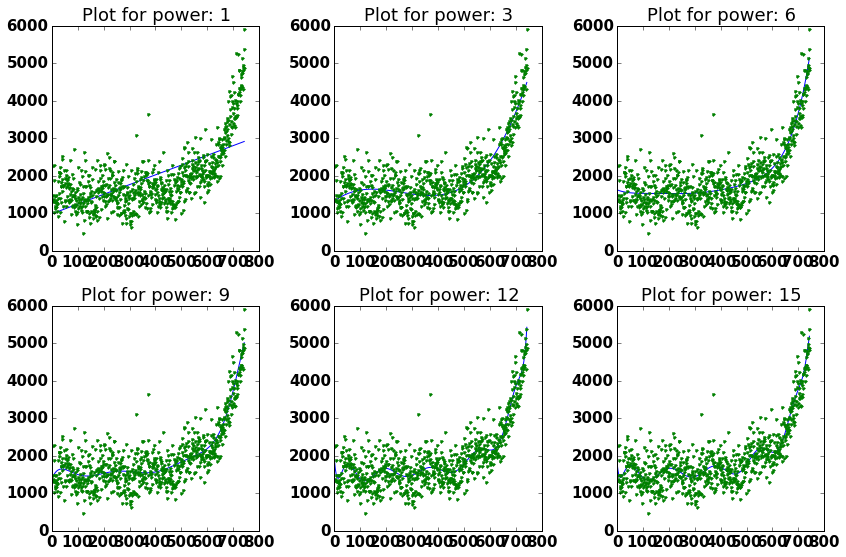

In [43]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

In [17]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.2e+08,9.9e+02,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,1.8e+08,2e+03,-5.3,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.4e+08,1.3e+03,4.9,-0.024,3e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.3e+08,1.7e+03,-5.8,0.041,-0.0001,9e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1.2e+08,1.5e+03,2.2,-0.034,0.00016,-3.1e-07,2.2e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,1.2e+08,1.6e+03,-2.8,0.033,-0.00019,5.9e-07,-8.5e-10,4.8e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,1.2e+08,1.5e+03,3.5,-0.08,0.00065,-2.5e-06,5.1e-09,-5.3e-12,2.2e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,1.2e+08,1.3e+03,22,-0.5,0.0048,-2.3e-05,6.3e-08,-9.5e-11,7.6e-14,-2.5e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,1.2e+08,1.4e+03,17,-0.35,0.0029,-1.1e-05,1.7e-08,7.1e-12,-5.8e-14,7.1e-17,-2.9e-20,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,1.2e+08,1.3e+03,33,-0.94,0.012,-8.5e-05,3.7e-07,-1e-09,1.9e-12,-2.1e-15,1.4e-18,-3.7e-22,NaN,NaN,NaN,NaN,NaN


In [18]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

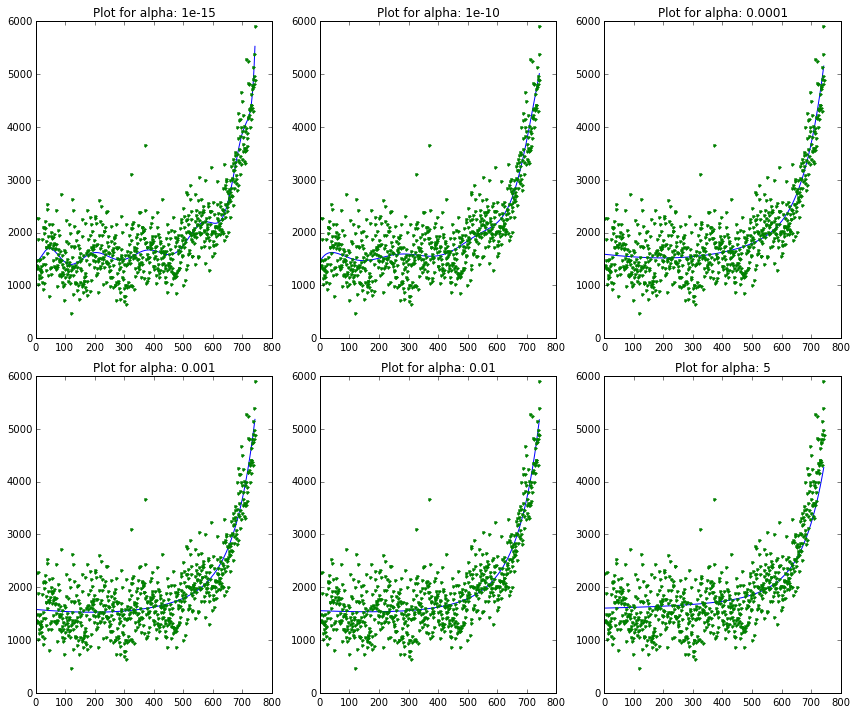

In [19]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

In [20]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,1.1e+08,1.5e+03,-13,1.2,-0.031,0.00037,-2.4e-06,8.6e-09,-1.7e-11,1.2e-14,1.5e-17,-2.4e-20,-2.1e-23,5.5e-26,-1.3e-29,-2.9e-32,1.6e-35
alpha_1e-10,1.2e+08,1.5e+03,10,-0.19,0.0013,-3.9e-06,4e-09,-1.8e-13,1.8e-15,1.9e-18,-1.3e-20,-2.1e-23,1.8e-26,7.6e-29,1.9e-32,-2.1e-34,1.3e-37
alpha_1e-08,1.2e+08,1.6e+03,2.8,-0.064,0.00043,-1e-06,3.1e-10,1.4e-12,6.2e-16,-1.5e-18,-2.9e-21,-1.8e-24,2.1e-27,6.1e-30,5.2e-33,-3.6e-36,-7.3e-39
alpha_0.0001,1.2e+08,1.6e+03,-0.62,0.001,1.3e-06,1.7e-09,1e-12,-1.6e-15,-5.2e-18,-6.5e-21,-1.6e-24,1.3e-26,3.8e-29,6.5e-32,7.5e-35,2.2e-38,-1.8e-40
alpha_0.001,1.2e+08,1.6e+03,-0.5,0.00092,1e-06,7.8e-10,4e-13,7.9e-17,1.5e-19,1.1e-21,3.5e-24,7.6e-27,1.4e-29,2e-32,2.5e-35,2.1e-38,-6.9e-43
alpha_0.01,1.2e+08,1.6e+03,-0.21,0.0004,6.8e-07,8.5e-10,1e-12,1.2e-15,1.6e-18,2.2e-21,3.4e-24,5.1e-27,7.8e-30,1.2e-32,1.6e-35,2.3e-38,3e-41
alpha_1,1.3e+08,1.5e+03,0.12,0.00022,3.7e-07,5.8e-10,8.7e-13,1.3e-15,1.8e-18,2.6e-21,3.7e-24,5.2e-27,7.3e-30,1e-32,1.4e-35,1.9e-38,2.7e-41
alpha_5,1.6e+08,1.6e+03,0.12,0.0002,3.1e-07,4.6e-10,6.8e-13,9.9e-16,1.4e-18,2e-21,2.8e-24,4e-27,5.5e-30,7.6e-33,1.1e-35,1.5e-38,2e-41
alpha_10,2e+08,1.7e+03,0.1,0.00016,2.5e-07,3.7e-10,5.4e-13,7.8e-16,1.1e-18,1.6e-21,2.2e-24,3.1e-27,4.3e-30,6e-33,8.3e-36,1.1e-38,1.6e-41
alpha_20,2.7e+08,1.8e+03,0.075,0.00011,1.7e-07,2.6e-10,3.8e-13,5.5e-16,7.9e-19,1.1e-21,1.6e-24,2.2e-27,3e-30,4.2e-33,5.8e-36,7.9e-39,1.1e-41


In [21]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

In [22]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


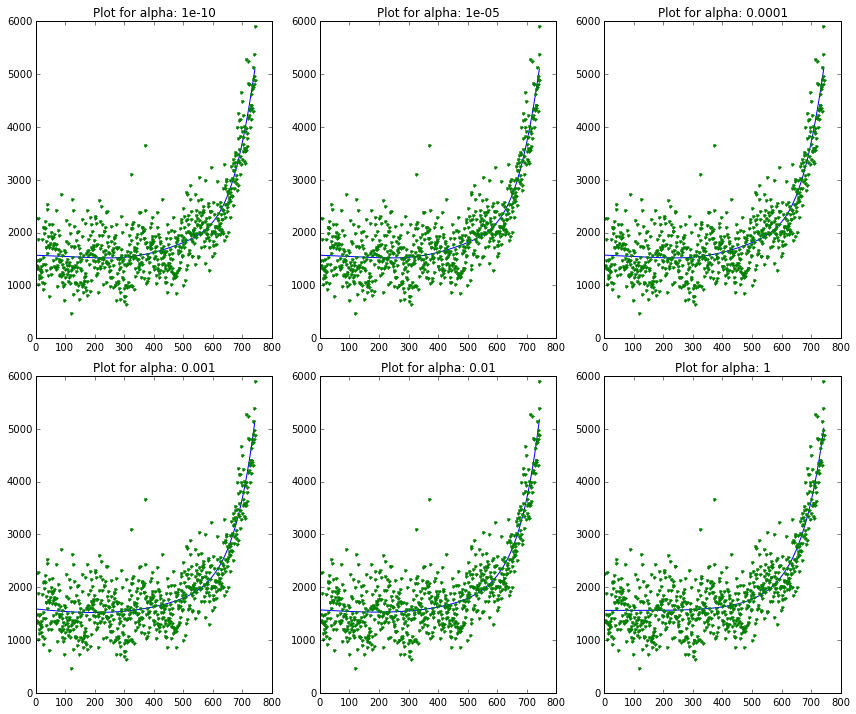

In [23]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)